### Preprocessing Our Data
Here we are going to preprocess our data and prepare it for the modeling

In [1]:
import pandas as pd
df = pd.read_csv("/kaggle/input/arxiv-multi-label-text-classification-datasets/arxiv34k6L.csv")
df.head()

,Abstracts,categories
0,Reusing features in deep networks through dens...,['cs.CV']
1,Visual defect detection (VDD) for high-mix low...,['cs.CV']
2,Dense object detectors rely on the sliding-win...,['cs.CV']
3,The state-of-the-art object detection and imag...,['cs.CV']
4,This paper explores self-supervised learning o...,['cs.CV']


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34068 entries, 0 to 34067
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Abstracts   34068 non-null  object
 1   categories  34068 non-null  object
dtypes: object(2)
memory usage: 532.4+ KB


In [3]:
df.describe()

,Abstracts,categories
count,34068,34068
unique,27256,6
top,Graph Representation Learning (GRL) is an infl...,['cs.LG']
freq,6,8140


In [4]:
len(df)

34068

In [5]:
sum(df["Abstracts"].duplicated())

6812

In [6]:
specific_duplicates = df[df['Abstracts'].duplicated()]
specific_duplicates

,Abstracts,categories
1845,The paradigm of self-supervision focuses on re...,['cs.CV']
1913,The linear take-make-dispose paradigm at the f...,['cs.CV']
1915,Self-supervised masked image modeling has show...,['cs.CV']
1916,Satellite Image Time Series (SITS) representat...,['cs.CV']
1928,"Despite its clinical utility, medical image se...",['cs.CV']
...,...,...
34052,Variational autoencoders (VAEs) are a powerful...,"['cs.LG', 'stat.ML']"
34053,Graph Attention Network (GAT) and GraphSAGE ar...,"['cs.LG', 'stat.ML']"
34060,The robustness of machine learning algorithms ...,"['cs.LG', 'stat.ML']"
34061,The real-world data usually exhibits heterogen...,"['cs.LG', 'stat.ML']"


In [7]:
new_df = df[~df['Abstracts'].duplicated()]
new_df

,Abstracts,categories
0,Reusing features in deep networks through dens...,['cs.CV']
1,Visual defect detection (VDD) for high-mix low...,['cs.CV']
2,Dense object detectors rely on the sliding-win...,['cs.CV']
3,The state-of-the-art object detection and imag...,['cs.CV']
4,This paper explores self-supervised learning o...,['cs.CV']
...,...,...
34062,One of the main challenges in imitation learni...,"['cs.LG', 'stat.ML']"
34064,The wide-spread adoption of representation lea...,"['cs.LG', 'stat.ML']"
34065,This work pioneers regret analysis of risk-sen...,"['cs.LG', 'stat.ML']"
34066,Graphs arise naturally in many real-world appl...,"['cs.LG', 'stat.ML']"


In [8]:
sum(new_df["Abstracts"].duplicated())

0

In [9]:
new_df.groupby("categories").count()

,Abstracts
categories,
"['cs.CV', 'cs.AI']",2692
"['cs.CV', 'cs.LG']",2691
['cs.CV'],7593
"['cs.LG', 'cs.AI']",4475
"['cs.LG', 'stat.ML']",3641
['cs.LG'],6164


In [10]:
new_df.shape

(27256, 2)

In [11]:
new_df["categories"][0][0] # since the elements in this columns are strings we need to convert them to list

'['

In [12]:
import ast
new_df.loc[:, "categories"] = new_df["categories"].apply(lambda x: ast.literal_eval(x))

In [13]:
new_df["categories"].values

array([list(['cs.CV']), list(['cs.CV']), list(['cs.CV']), ...,
       list(['cs.LG', 'stat.ML']), list(['cs.LG', 'stat.ML']),
       list(['cs.LG', 'stat.ML'])], dtype=object)

#### Split Data In Train, Test, And Val

In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(new_df, test_size = 0.1, stratify = new_df['categories'].values)

In [15]:
train_df.shape, test_df.shape

((24530, 2), (2726, 2))

In [16]:
val_df = test_df.sample(frac = 0.5)
val_df.shape

(1363, 2)

In [17]:
test_df.drop(val_df.index, inplace = True)
test_df.shape

(1363, 2)

In [18]:
train_df["Abstracts"].apply(lambda x: len(x.split(" "))).describe()  # for selecting sequence lengths 

count    24530.000000
mean       161.982715
std         40.097926
min          5.000000
25%        134.000000
50%        161.000000
75%        188.000000
max        317.000000
Name: Abstracts, dtype: float64

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

2024-06-01 05:36:52.749673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 05:36:52.749784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 05:36:52.875906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
# binarize the mulit-labels
labels = tf.ragged.constant(train_df["categories"].values)
mlb = tf.keras.layers.StringLookup(output_mode = "multi_hot")
mlb.adapt(labels)
vocab = mlb.get_vocabulary()
print(vocab)

['[UNK]', 'cs.LG', 'cs.CV', 'cs.AI', 'stat.ML']


In [21]:
# to reverse back from the multi hot
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [22]:
sequence_length = 160 # based on mean value above 
batch_size = 128

In [23]:
def make_dataset(df, is_train = True):
    """A function to create dataset from the learned Binarizer"""
    labels = tf.ragged.constant(df["categories"].values)
    label_binarized = mlb(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices((df["Abstracts"].values, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [24]:
train_data = make_dataset(train_df, is_train=True)
val_data = make_dataset(val_df, is_train=False)
test_data = make_dataset(test_df, is_train=False)

In [25]:
text_batch, label_batch = next(iter(train_data))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print("___")

Abstract: b'In this paper, we propose a graph neural network architecture to solve the AC\npower flow problem under realistic constraints. To ensure a safe and resilient\noperation of distribution grids, AC power flow calculations are the means of\nchoice to determine grid operating limits or analyze grid asset utilization in\nplanning procedures. In our approach, we demonstrate the development of a\nframework that uses graph neural networks to learn the physical constraints of\nthe power flow. We present our model architecture on which we perform\nunsupervised training to learn a general solution of the AC power flow\nformulation independent of the specific topologies and supply tasks used for\ntraining. Finally, we demonstrate, validate and discuss our results on medium\nvoltage benchmark grids. In our approach, we focus on the physical and\ntopological properties of distribution grids to provide scalable solutions for\nreal grid topologies. Therefore, we take a data-driven approach,

In [26]:
# unique words in the abstracts
vocabulary = set()
train_df["Abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

136829


In [27]:
auto = tf.data.AUTOTUNE
vectorizer_layer = layers.TextVectorization(
    max_tokens=vocabulary_size, output_mode = "int", output_sequence_length = sequence_length
)

train_ds = train_data.map(lambda x, y: x)
vectorizer_layer.adapt(train_ds)

In [28]:
def vectorize_text(text, label):
    return vectorizer_layer(text), label

train_ds = train_data.map(vectorize_text, num_parallel_calls=auto).cache().prefetch(auto)
val_ds = val_data.map(vectorize_text, num_parallel_calls=auto).cache().prefetch(auto)
test_ds = test_data.map(vectorize_text, num_parallel_calls=auto).cache().prefetch(auto)

In [29]:
text_batch, label_batch = next(iter(train_ds))
text_batch, label_batch

(<tf.Tensor: shape=(128, 160), dtype=int64, numpy=
 array([[  29,   60,   11, ...,  180, 1743,   84],
        [7722,   11,  121, ...,  123,    2, 2039],
        [2472, 7812,  131, ...,    0,    0,    0],
        ...,
        [   6,   75, 5413, ...,    0,    0,    0],
        [ 827,  452,   11, ...,  162,    2,   65],
        [1424,  205,  240, ...,  275,  226,  331]])>,
 <tf.Tensor: shape=(128, 5), dtype=int64, numpy=
 array([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0],
   

In [30]:
vocabulary_size

136829

In [49]:
# define the metrics we will be using for all our models
f1_normal = keras.metrics.F1Score(average=None, threshold=0.5, name="f1_normal")
f1_micro = keras.metrics.F1Score(average="micro", threshold=0.5, name="f1_micro")
f1_macro = keras.metrics.F1Score(average="macro", threshold=0.5, name="f1_macro")
f1_weighted = keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_weighted")

#### Dense Model

In [68]:
from keras.models import Sequential
from keras.layers import Dense

model1 = Sequential()
model1.add(keras.layers.Input(shape = (160,)))
model1.add(Dense(512, activation = "relu"))
model1.add(Dense(256, activation = "relu"))
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(len(vocab), activation = "sigmoid"))

model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 512)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,237 (997.02 KB)

 Trainable params: 255,237 (997.02 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model1.compile(loss = "binary_crossentropy",
               optimizer = keras.optimizers.Adam(),
               metrics = [f1_normal, f1_micro, f1_macro, f1_weighted])
history1 = model1.fit(train_ds, validation_data = val_ds, epochs = 50)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - f1_macro: 0.2911 - f1_micro: 0.4691 - f1_normal: 0.2911 - f1_weighted: 0.4630 - loss: 4.9006 - val_f1_macro: 0.1779 - val_f1_micro: 0.3422 - val_f1_normal: 0.1779 - val_f1_weighted: 0.3166 - val_loss: 0.6508
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_macro: 0.2929 - f1_micro: 0.5018 - f1_normal: 0.2929 - f1_weighted: 0.4812 - loss: 0.7226 - val_f1_macro: 0.2483 - val_f1_micro: 0.4867 - val_f1_normal: 0.2483 - val_f1_weighted: 0.4391 - val_loss: 0.5173
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_macro: 0.2862 - f1_micro: 0.5297 - f1_normal: 0.2862 - f1_weighted: 0.4887 - loss: 0.5302 - val_f1_macro: 0.2604 - val_f1_micro: 0.5525 - val_f1_normal: 0.2604 - val_f1_weighted: 0.4793 - val_loss: 0.5024
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_macro: 0.2939 - f1_micro: 0.5566 - f1_normal: 0.2939 - f1_weighted: 0.5061 - loss: 0.4899 - val_f1_macro: 0.2133 - val_f1_micro: 0.4423 - val_f1_normal: 0.21

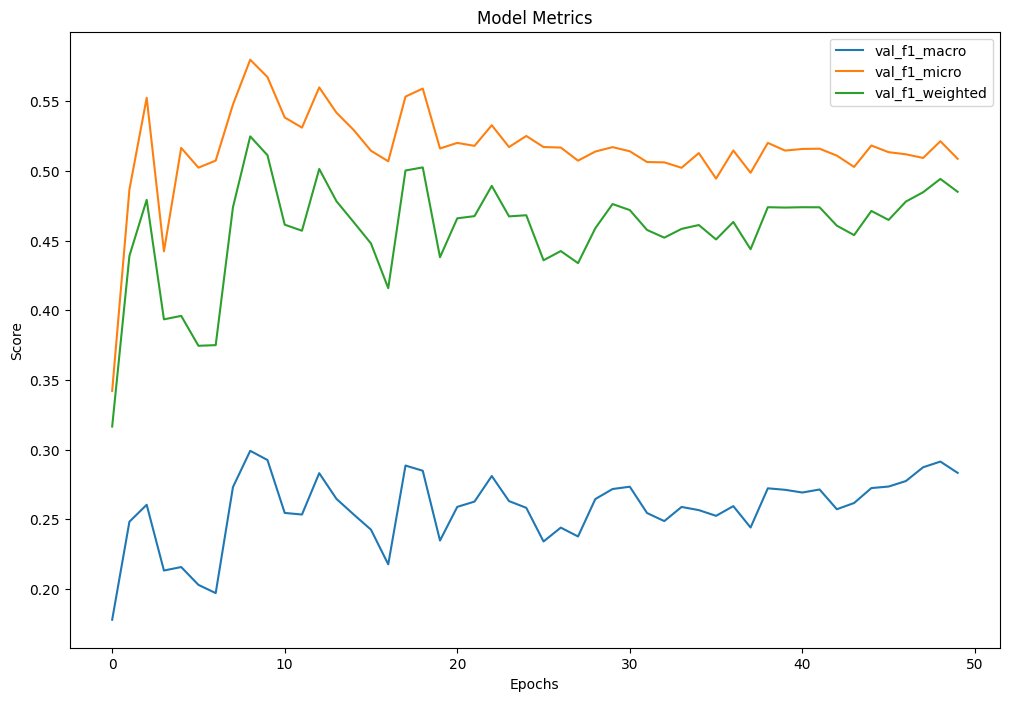

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['val_f1_macro', 'val_f1_micro', 'val_f1_weighted']
    plt.figure(figsize=(12, 8))
    
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.title('Model Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend(loc='upper right')
    plt.show()

plot_metrics(history1)

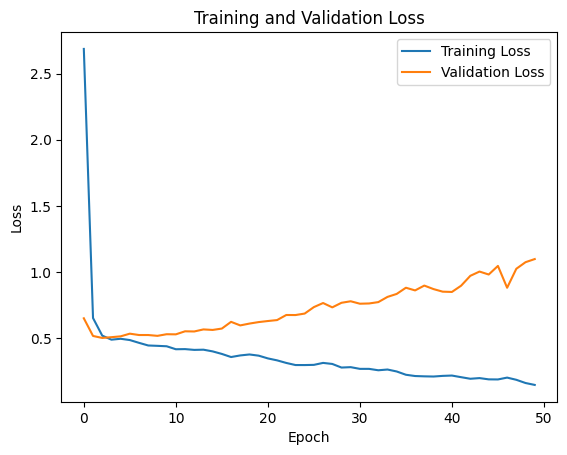

In [72]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history1)

In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix, hamming_loss
def model_results(model, data):
    """
    Evaluates the performance of a multi-label classification model using different averaging techniques.

    """
    y_pred_probs = model.predict(data)
    y_true = np.concatenate([y for x, y in data], axis=0)
    y_pred = (y_pred_probs > 0.5).astype(int)
    
    hamming = hamming_loss(y_true, y_pred)
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    print(f"Hamming Loss: {hamming}")
    print(f"Confusion Matrix:")
    print(mcm)
    print("\n")
    for averaging in ['micro', 'macro', 'weighted']:
        f1 = f1_score(y_true, y_pred, average=averaging, zero_division=1)
        precision = precision_score(y_true, y_pred, average=averaging, zero_division=1)
        recall = recall_score(y_true, y_pred, average=averaging, zero_division=1)
        if averaging == 'micro':
            description = "Micro-averaging computes metrics globally by considering each element of the label set as a binary prediction."
        elif averaging == 'macro':
            description = "Macro-averaging computes metrics for each class independently and then takes the average, treating all classes equally."
        elif averaging == 'weighted':
            description = "Weighted-averaging computes metrics for each class independently and then takes the average, weighted by the number of true instances for each class."
        
        print(f"Averaging Technique ({averaging}):{description}")
        print(f"F1 Score: {f1}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print("\n")

In [73]:
model_results(model1, val_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Hamming Loss: 0.2851063829787234
Confusion Matrix:
[[[1363    0]
  [   0    0]]

 [[ 194  314]
  [ 241  614]]

 [[ 407  302]
  [ 340  314]]

 [[ 753  256]
  [ 277   77]]

 [[1149   29]
  [ 184    1]]]


Averaging Technique (micro):Micro-averaging computes metrics globally by considering each element of the label set as a binary prediction.
F1 Score: 0.5087231352718079
Precision: 0.5275301520713161
Recall: 0.4912109375


Averaging Technique (macro):Macro-averaging computes metrics for each class independently and then takes the average, treating all classes equally.
F1 Score: 0.4833360814097599
Precision: 0.4871885510678614
Recall: 0.48423410176579457


Averaging Technique (weighted):Weighted-averaging computes metrics for each class independently and then takes the average, weighted by the number of true instances for each class.
F1 Score: 0.48502509133156313
Precision: 0.48197904464215585
Recall: 0.4912109375




In [36]:
model_results(model1, test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Hamming Loss: 0.27953044754218637
Confusion Matrix:
[[[1363    0]
  [   0    0]]

 [[ 260  260]
  [ 415  428]]

 [[ 591  129]
  [ 536  107]]

 [[ 978   22]
  [ 353   10]]

 [[1173   11]
  [ 179    0]]]


Averaging Technique (micro):Micro-averaging computes metrics globally by considering each element of the label set as a binary prediction.
F1 Score: 0.3639398998330551
Precision: 0.5635987590486039
Recall: 0.2687376725838264


Averaging Technique (macro):Macro-averaging computes metrics for each class independently and then takes the average, treating all classes equally.
F1 Score: 0.37064061572751206
Precision: 0.4775965707528577
Recall: 0.3403332463813578


Averaging Technique (weighted):Weighted-averaging computes metrics for each class independently and then takes the average, weighted by the number of true instances for each class.
F1 Score: 0.31866602697979846
Precision: 0.45827987160828415
Recall: 0.2687376725838264




In [74]:
model1.save('model1.keras')

### ConvNets

In [97]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr_on_plateu = ReduceLROnPlateau(monitor = "val_f1_weighted", factor = 0.5, patience = 3, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, mode='min', verbose = 1, restore_best_weights=True)

inputs = layers.Input(shape=(160,))
x = layers.Embedding(vocabulary_size, 128)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, kernel_size=3, padding="valid", activation='relu', strides=3)(x)  
x = layers.Conv1D(128, kernel_size=3, padding="valid", activation='relu', strides=3)(x)
x = layers.Conv1D(64, kernel_size = 3, padding = "valid", activation = 'relu', strides = 3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(vocab), activation="sigmoid", name="outputs")(x)
model2 = keras.Model(inputs, outputs)

model2.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 160, 128)       │    17,514,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 160, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 53, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 17, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 5, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,654,213 (67.35 MB)

 Trainable params: 17,654,213 (67.35 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
model2.compile(loss = "binary_crossentropy",
               optimizer = keras.optimizers.Adam(),
               metrics = [f1_normal, f1_micro, f1_macro, f1_weighted])
history2 = model2.fit(train_ds, validation_data = val_ds, epochs = 30, callbacks = [reduce_lr_on_plateu, early_stopping])

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - f1_macro: 0.2766 - f1_micro: 0.5386 - f1_normal: 0.2766 - f1_weighted: 0.4893 - loss: 0.5290 - val_f1_macro: 0.3609 - val_f1_micro: 0.7598 - val_f1_normal: 0.3609 - val_f1_weighted: 0.6628 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 176ms/step - f1_macro: 0.3860 - f1_micro: 0.7651 - f1_normal: 0.3860 - f1_weighted: 0.6837 - loss: 0.2922 - val_f1_macro: 0.3648 - val_f1_micro: 0.7687 - val_f1_normal: 0.3648 - val_f1_weighted: 0.6702 - val_loss: 0.2780 - learning_rate: 0.0010
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - f1_macro: 0.3786 - f1_micro: 0.7883 - f1_normal: 0.3786 - f1_weighted: 0.6902 - loss: 0.2548 - val_f1_macro: 0.3626 - val_f1_micro: 0.7641 - val_f1_normal: 0.3626 - val_f1_weighted: 0.6661 - val_loss: 0.2993 - learning_rate: 0.0010
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - f1_macro: 0.3795 - f1_micro: 0.7983 - f1_normal: 0.3795 - f1_weighted: 0.6955

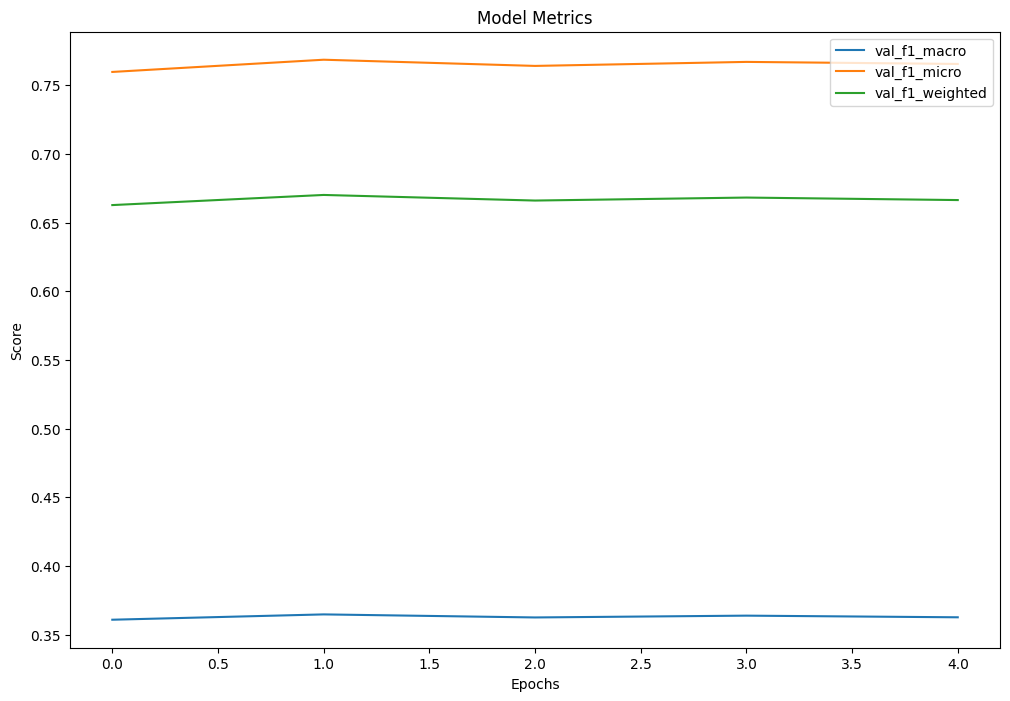

In [100]:
plot_metrics(history2)

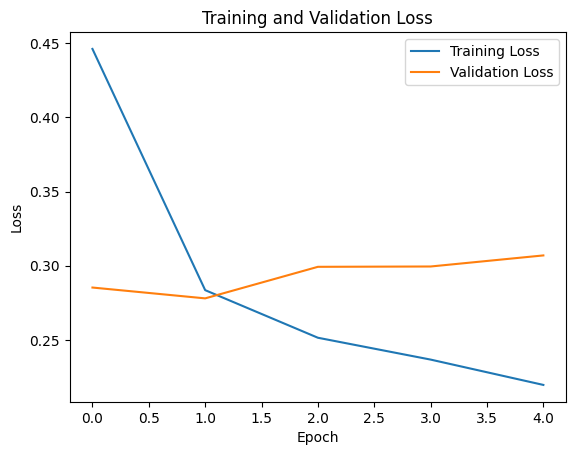

In [101]:
plot_loss(history2)

In [102]:
model_results(model2, val_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Hamming Loss: 0.11782831988261189
Confusion Matrix:
[[[1363    0]
  [   0    0]]

 [[ 461   47]
  [ 126  729]]

 [[ 667   42]
  [  49  605]]

 [[1009    0]
  [ 354    0]]

 [[1178    0]
  [ 185    0]]]


Averaging Technique (micro):Micro-averaging computes metrics globally by considering each element of the label set as a binary prediction.
F1 Score: 0.7686545664073754
Precision: 0.9374560787069571
Recall: 0.6513671875


Averaging Technique (macro):Macro-averaging computes metrics for each class independently and then takes the average, treating all classes equally.
F1 Score: 0.5647967817992197
Precision: 0.9749035994837394
Recall: 0.5555416063093513


Averaging Technique (weighted):Weighted-averaging computes metrics for each class independently and then takes the average, weighted by the number of true instances for each class.
F1 Score: 0.6701979626141532
Precision: 0.9539847662303041
Recall: 0.6513671875




In [103]:
model_results(model2, test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Hamming Loss: 0.11621423330887748
Confusion Matrix:
[[[1363    0]
  [   0    0]]

 [[ 460   60]
  [  97  746]]

 [[ 685   35]
  [  58  585]]

 [[1000    0]
  [ 363    0]]

 [[1184    0]
  [ 179    0]]]


Averaging Technique (micro):Micro-averaging computes metrics globally by considering each element of the label set as a binary prediction.
F1 Score: 0.7707006369426752
Precision: 0.9333800841514727
Recall: 0.6563116370808678


Averaging Technique (macro):Macro-averaging computes metrics for each class independently and then takes the average, treating all classes equally.
F1 Score: 0.5662313156033527
Precision: 0.9738213399503722
Recall: 0.5589465159053886


Averaging Technique (weighted):Weighted-averaging computes metrics for each class independently and then takes the average, weighted by the number of true instances for each class.
F1 Score: 0.6698184596268436
Precision: 0.9511574311989467
Recall: 0.6563116370808678




In [105]:
model2.save("model2.keras")

### Recurrent 

In [110]:
inputs = keras.Input(shape = (160,))
x = layers.Embedding(vocabulary_size, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences = True))(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(16, activation = "relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(vocab), activation = "sigmoid", name = "predictions")(x)

model3 = keras.Model(inputs, outputs)
model3.compile(loss = "binary_crossentropy",
               optimizer = keras.optimizers.Adam(),
               metrics = [f1_normal, f1_micro, f1_macro, f1_weighted])

print("Model Summary:")
model3.summary()

history3 = model3.fit(train_ds, validation_data = val_ds, epochs = 30, callbacks = [reduce_lr_on_plateu, early_stopping])

Model Summary:


Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 160, 128)       │    17,514,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 160, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 160, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,655,269 (67.35 MB)

 Trainable params: 17,655,269 (67.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 114s 561ms/step - f1_macro: 0.3264 - f1_micro: 0.5017 - f1_normal: 0.3264 - f1_weighted: 0.5134 - loss: 0.5867 - val_f1_macro: 0.3634 - val_f1_micro: 0.7646 - val_f1_normal: 0.3634 - val_f1_weighted: 0.6670 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 107s 557ms/step - f1_macro: 0.4188 - f1_micro: 0.7313 - f1_normal: 0.4188 - f1_weighted: 0.6924 - loss: 0.3540 - val_f1_macro: 0.3636 - val_f1_micro: 0.7642 - val_f1_normal: 0.3636 - val_f1_weighted: 0.6675 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 108s 560ms/step - f1_macro: 0.3901 - f1_micro: 0.7618 - f1_normal: 0.3901 - f1_weighted: 0.6823 - loss: 0.3009 - val_f1_macro: 0.3610 - val_f1_micro: 0.7601 - val_f1_normal: 0.3610 - val_f1_weighted: 0.6635 - val_loss: 0.2974 - learning_rate: 0.0010
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
plot_loss(history3)

In [ ]:
plot_metrics(history3)

In [ ]:
model_results(model3, test_ds)

In [ ]:
model3.save('model3.keras')